In [1]:
import sklearn as skl
import pickle as pkl
import pandas as pd
import numpy as np

import sklearn.model_selection
import sklearn.svm
import sklearn.metrics

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import seaborn as sns

from itertools import chain

In [2]:
import scipy as sp

In [3]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

In [4]:
import sys
sys.path.append("..") # or wherever the package is
import kuanglu

In [5]:
import scanpy as sc

In [6]:
import pickle as pkl

In [7]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "4"

## Create dataloaders

Note: samples must have the same number of genes (and of course in the same order). They can, however, have different number of cells, but you'll only be able to use `batch_size = 1`, because we matrices with different sizes cannot form a tensor.

It is possible in the future, by flanking them with zeros and carefully masking them out in several steps.

In [8]:
adata = sc.read_h5ad("../../mouse-brain/merfish.h5ad")
adata.obs['donor_slice'] = adata.obs['donor_id'].astype(str) + '_' + adata.obs['slice'].astype(str)
ids = adata.obs['donor_slice'].unique().tolist()

In [9]:
train_Xs = []
for i in ids:
    train_Xs.append(np.array(adata.X[adata.obs['donor_slice'] == i, :]))
    
validate_Xs = []
chosen_donors = ids[0:1]
for i in chosen_donors:
    validate_Xs.append(np.array(adata.X[adata.obs['donor_slice'] == i, :]))
    
_, p = train_Xs[0].shape

class MyDataSet(Data.Dataset):
    def __init__(self, Xs):
        super(MyDataSet, self).__init__()
        self.Xs = [torch.Tensor(X) for X in Xs]
        
    def __len__(self):
        return len(self.Xs)

    def __getitem__(self, idx):
        return self.Xs[idx]

train_data = MyDataSet(train_Xs)
train_loader = Data.DataLoader(train_data, batch_size=1, shuffle=True) 

print("Training data dimensions:")
for i in train_Xs:
    print(i.shape)

validate_data = MyDataSet(validate_Xs)
validate_loader = Data.DataLoader(validate_data, batch_size=1, shuffle=True)

print("Validation data dimensions:")
for i in validate_Xs:
    print(i.shape)

Training data dimensions:
(21002, 374)
(24790, 374)
(15694, 374)
(15844, 374)
(19503, 374)
(11047, 374)
(10890, 374)
(9571, 374)
(10744, 374)
(8983, 374)
(9644, 374)
(9462, 374)
(8164, 374)
(8281, 374)
(11398, 374)
(10609, 374)
(10785, 374)
(14122, 374)
(12180, 374)
(12036, 374)
(10268, 374)
(12421, 374)
(11179, 374)
(9665, 374)
(9617, 374)
(8823, 374)
(7545, 374)
(14195, 374)
(7215, 374)
(15738, 374)
(17503, 374)
Validation data dimensions:
(21002, 374)


In [10]:
embed_config = {
    'embedType': 'ff',
    'ldim': [374, 512, 256, 128],
}

model = kuanglu.Model(d_gene=p, 
                      d_denoise = [p], 
                      d_quality=[512, 256, 1], 
                      lbd=1.,
                      embed_config=embed_config,
                      ).to('cuda')

In [11]:
rec = model.fit('denoised', train_loader, validate_loader, [0, 100],
                fix=['embed', 'qualify', 'smooth', 'interact'], lr=1e-4)

G:\kuanglu\examples\..\kuanglu\model.py:312: UserWarning: Parameter containing:
tensor(100., device='cuda:0') is already fixed. They will be unfixed when exiting this function.
  warnings.warn(f"{param} is already fixed. They will be unfixed when exiting this function.")


Epoch 0001 Train MSE 1.014 Validate MSE 1.157 Raw MSE 1.145
Epoch 0002 Train MSE 0.998 Validate MSE 1.104 Raw MSE 1.099
Epoch 0003 Train MSE 0.994 Validate MSE 1.111 Raw MSE 1.115
Epoch 0004 Train MSE 0.983 Validate MSE 1.113 Raw MSE 1.125
Epoch 0005 Train MSE 0.974 Validate MSE 1.070 Raw MSE 1.095
Epoch 0006 Train MSE 0.970 Validate MSE 1.059 Raw MSE 1.090
Epoch 0007 Train MSE 0.955 Validate MSE 1.052 Raw MSE 1.088
Epoch 0008 Train MSE 0.952 Validate MSE 1.061 Raw MSE 1.111
Epoch 0009 Train MSE 0.945 Validate MSE 1.051 Raw MSE 1.108
Epoch 0010 Train MSE 0.935 Validate MSE 1.050 Raw MSE 1.108
Epoch 0011 Train MSE 0.932 Validate MSE 1.029 Raw MSE 1.092
Epoch 0012 Train MSE 0.918 Validate MSE 1.031 Raw MSE 1.106
Epoch 0013 Train MSE 0.918 Validate MSE 1.044 Raw MSE 1.119
Epoch 0014 Train MSE 0.917 Validate MSE 1.036 Raw MSE 1.114
Epoch 0015 Train MSE 0.904 Validate MSE 1.014 Raw MSE 1.103
Epoch 0016 Train MSE 0.908 Validate MSE 1.014 Raw MSE 1.099
Epoch 0017 Train MSE 0.903 Validate MSE 

In [12]:
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [100, 125],
                                           fix=['denoise', 'interact'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [125, 200],
                                           fix=['interact'], lr=1e-4))

Epoch 0101 Train MSE 0.941 Validate MSE 1.041 Raw MSE 1.105
Epoch 0102 Train MSE 0.911 Validate MSE 1.034 Raw MSE 1.118
Epoch 0103 Train MSE 0.889 Validate MSE 0.992 Raw MSE 1.089
Epoch 0104 Train MSE 0.882 Validate MSE 0.997 Raw MSE 1.098
Epoch 0105 Train MSE 0.881 Validate MSE 1.001 Raw MSE 1.119
Epoch 0106 Train MSE 0.880 Validate MSE 0.979 Raw MSE 1.086
Epoch 0107 Train MSE 0.875 Validate MSE 0.983 Raw MSE 1.095
Epoch 0108 Train MSE 0.874 Validate MSE 0.993 Raw MSE 1.103
Epoch 0109 Train MSE 0.872 Validate MSE 0.973 Raw MSE 1.085
Epoch 0110 Train MSE 0.870 Validate MSE 1.000 Raw MSE 1.089
Epoch 0111 Train MSE 0.866 Validate MSE 0.999 Raw MSE 1.099
Epoch 0112 Train MSE 0.872 Validate MSE 0.991 Raw MSE 1.102
Epoch 0113 Train MSE 0.869 Validate MSE 0.989 Raw MSE 1.113
Epoch 0114 Train MSE 0.868 Validate MSE 0.971 Raw MSE 1.100
Epoch 0115 Train MSE 0.870 Validate MSE 0.997 Raw MSE 1.100
Epoch 0116 Train MSE 0.871 Validate MSE 0.989 Raw MSE 1.110
Epoch 0117 Train MSE 0.871 Validate MSE 

In [13]:
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [200, 225],
                                           fix=['denoise', 'embed', 'qualify', 'smooth'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [225, 300], lr=1e-4))

Epoch 0201 Train MSE 0.841 Validate MSE 0.940 Raw MSE 1.092
Epoch 0202 Train MSE 0.842 Validate MSE 0.942 Raw MSE 1.099
Epoch 0203 Train MSE 0.839 Validate MSE 0.966 Raw MSE 1.118
Epoch 0204 Train MSE 0.839 Validate MSE 0.936 Raw MSE 1.100
Epoch 0205 Train MSE 0.838 Validate MSE 0.964 Raw MSE 1.121
Epoch 0206 Train MSE 0.838 Validate MSE 0.963 Raw MSE 1.118
Epoch 0207 Train MSE 0.831 Validate MSE 0.952 Raw MSE 1.101
Epoch 0208 Train MSE 0.837 Validate MSE 0.937 Raw MSE 1.092
Epoch 0209 Train MSE 0.833 Validate MSE 0.959 Raw MSE 1.115
Epoch 0210 Train MSE 0.838 Validate MSE 0.940 Raw MSE 1.088
Epoch 0211 Train MSE 0.833 Validate MSE 0.936 Raw MSE 1.103
Epoch 0212 Train MSE 0.834 Validate MSE 0.956 Raw MSE 1.121
Epoch 0213 Train MSE 0.831 Validate MSE 0.946 Raw MSE 1.110
Epoch 0214 Train MSE 0.832 Validate MSE 0.940 Raw MSE 1.089
Epoch 0215 Train MSE 0.829 Validate MSE 0.930 Raw MSE 1.094
Epoch 0216 Train MSE 0.833 Validate MSE 0.940 Raw MSE 1.098
Epoch 0217 Train MSE 0.831 Validate MSE 

Text(0, 0.5, 'MSE')

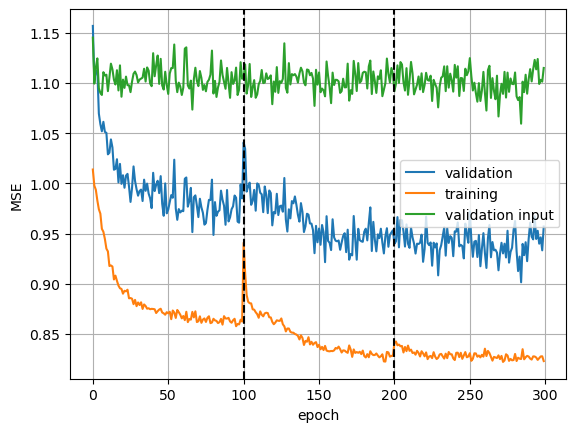

In [18]:
plt.plot(rec['validate_epoch'], rec['validate_mse'], label='validation')
plt.plot(rec['train_epoch'], rec['train_mse'], label='training')
plt.plot(rec['validate_epoch'], rec['raw_mse'], label='validation input')
plt.legend()
plt.grid()
plt.axvline(100, ls='--', c='k')
plt.axvline(200, ls='--', c='k')
plt.xlabel('epoch')
plt.ylabel('MSE')

In [19]:
mse_df = pd.DataFrame({'epoch': rec['validate_epoch'], 'mse': rec['validate_mse']})

def epoch2stage(x):
    if x < 75: return 'pre-denoise'
    elif x < 100: return 'denoise'
    elif x < 175: return 'pre-denoise-smooth'
    elif x < 200: return 'denoise-smooth'
    elif x < 275: return 'pre-denoise-smooth-enhance'
    elif x < 300: return 'denoise-smooth-enhance'
    else: raise NotImplementedError('x >= 400 not allowed')

mse_df['stage'] = mse_df['epoch'].apply(epoch2stage)
mse_df

,epoch,mse,stage
0,0,1.156877,pre-denoise
1,1,1.103940,pre-denoise
2,2,1.111223,pre-denoise
3,3,1.112873,pre-denoise
4,4,1.069522,pre-denoise
...,...,...,...
295,295,0.952751,denoise-smooth-enhance
296,296,0.939870,denoise-smooth-enhance
297,297,0.946224,denoise-smooth-enhance
298,298,0.933277,denoise-smooth-enhance


C:\Users\lshh\miniconda3\envs\torch_2.0.1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\lshh\miniconda3\envs\torch_2.0.1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\lshh\miniconda3\envs\torch_2.0.1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


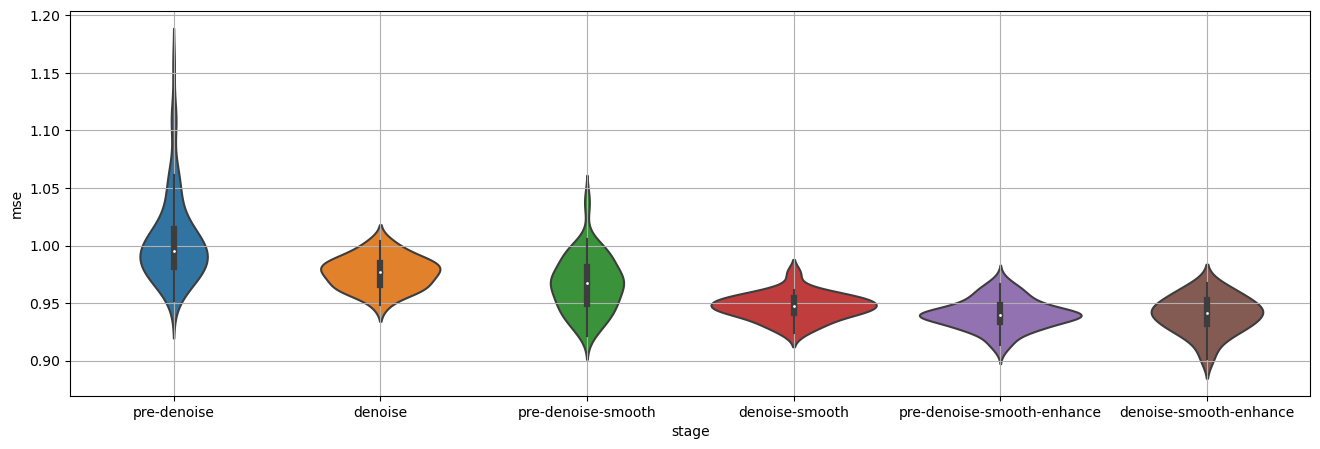

In [20]:
# sns.violinplot(mse_df[~mse_df['stage'].str.contains('pre-')], x='stage', y='mse')
plt.figure(figsize=(16, 5))
sns.violinplot(mse_df, x='stage', y='mse')
plt.grid()

In [21]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'])

print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise') / sum(mse_df['stage'] == 'denoise-smooth'))

p = 3.2057370198655616e-08 f = 0.9568000000000001


In [22]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth-enhance', 'mse'])
print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise-smooth') / sum(mse_df['stage'] == 'denoise-smooth-enhance'))

p = 0.1253189420819512 f = 0.6272


In [23]:
embeddings = []
model.eval()
emb = np.zeros((len(adata), 128))

with torch.no_grad():
    for X in train_loader:
        for i in ids:
            X = np.array(adata.X[adata.obs['donor_slice'] == i, :])
            y = adata.obs['donor_slice'] == i
            emb[y, :] = model.cell_embed(torch.tensor(X, dtype=torch.float32)[None, :, :].to('cuda')).cpu().detach().numpy()

In [24]:
adata.obsm['X_kuanglu'] = emb

In [25]:
with open("../comparisons/output/mouse-brain-374-kuanglu-emb.pkl", 'wb') as f:
    pkl.dump(emb, f)

In [26]:
sc.pp.neighbors(adata, use_rep='X_kuanglu')
sc.tl.umap(adata)

C:\Users\lshh\miniconda3\envs\torch_2.0.1\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
C:\Users\lshh\miniconda3\envs\torch_2.0.1\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\lshh\miniconda3\envs\torch_2.0.1\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\lshh\miniconda3\envs\torch_2.0.1\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: Futu

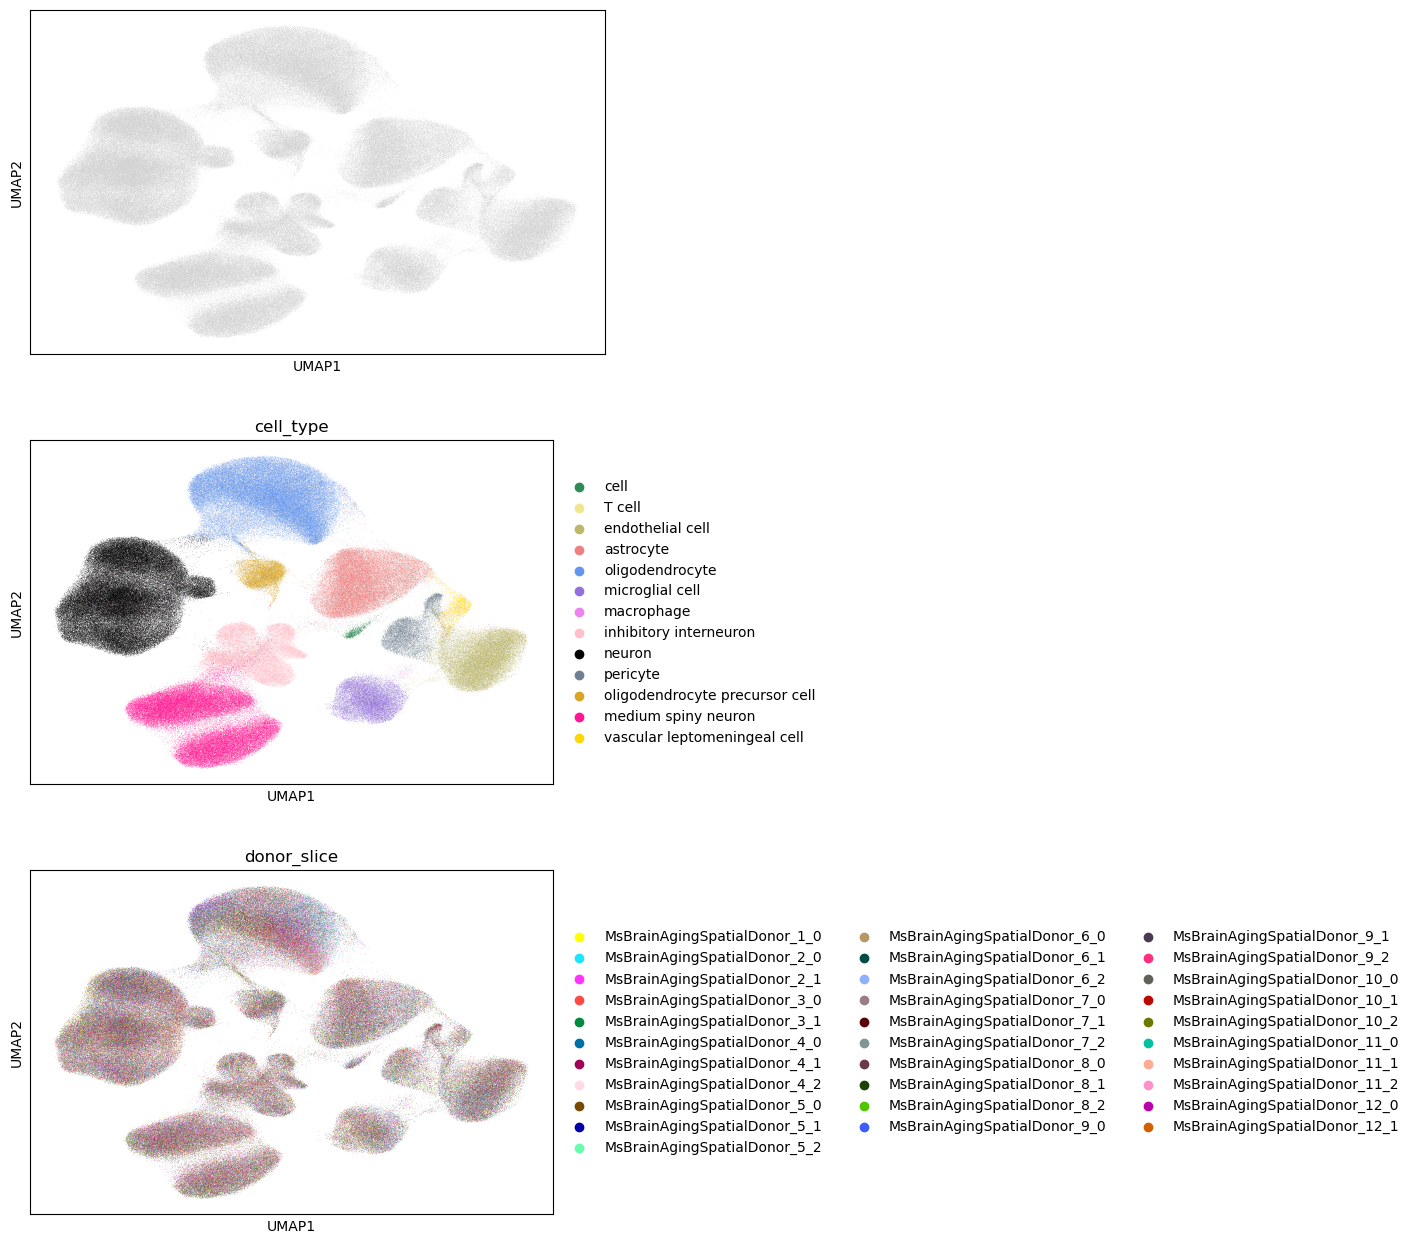

In [28]:
%matplotlib inline
sc.pl.umap(adata, color=[None, 'cell_type', 'donor_slice'], ncols=1)
pass

In [29]:
with open("../comparisons/output/mouse-brain-374-kuanglu-emb.pkl", 'wb') as f:
    pkl.dump(emb, f)